In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
%matplotlib inline
plt.style.use('seaborn')
from scipy.ndimage.filters import gaussian_filter1d
import os
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Initial Data

In [ ]:
BASE_DIR = '/content/drive/My Drive/4th Year/CS 197 (Thesis)/FINAL - COVID Modeling/notebooks'
file_path = os.path.join(BASE_DIR, 'data/normalized_5day_moving.csv')
moved_scaled = pd.read_csv(file_path)
moved_scaled.head()

### Load Graphs

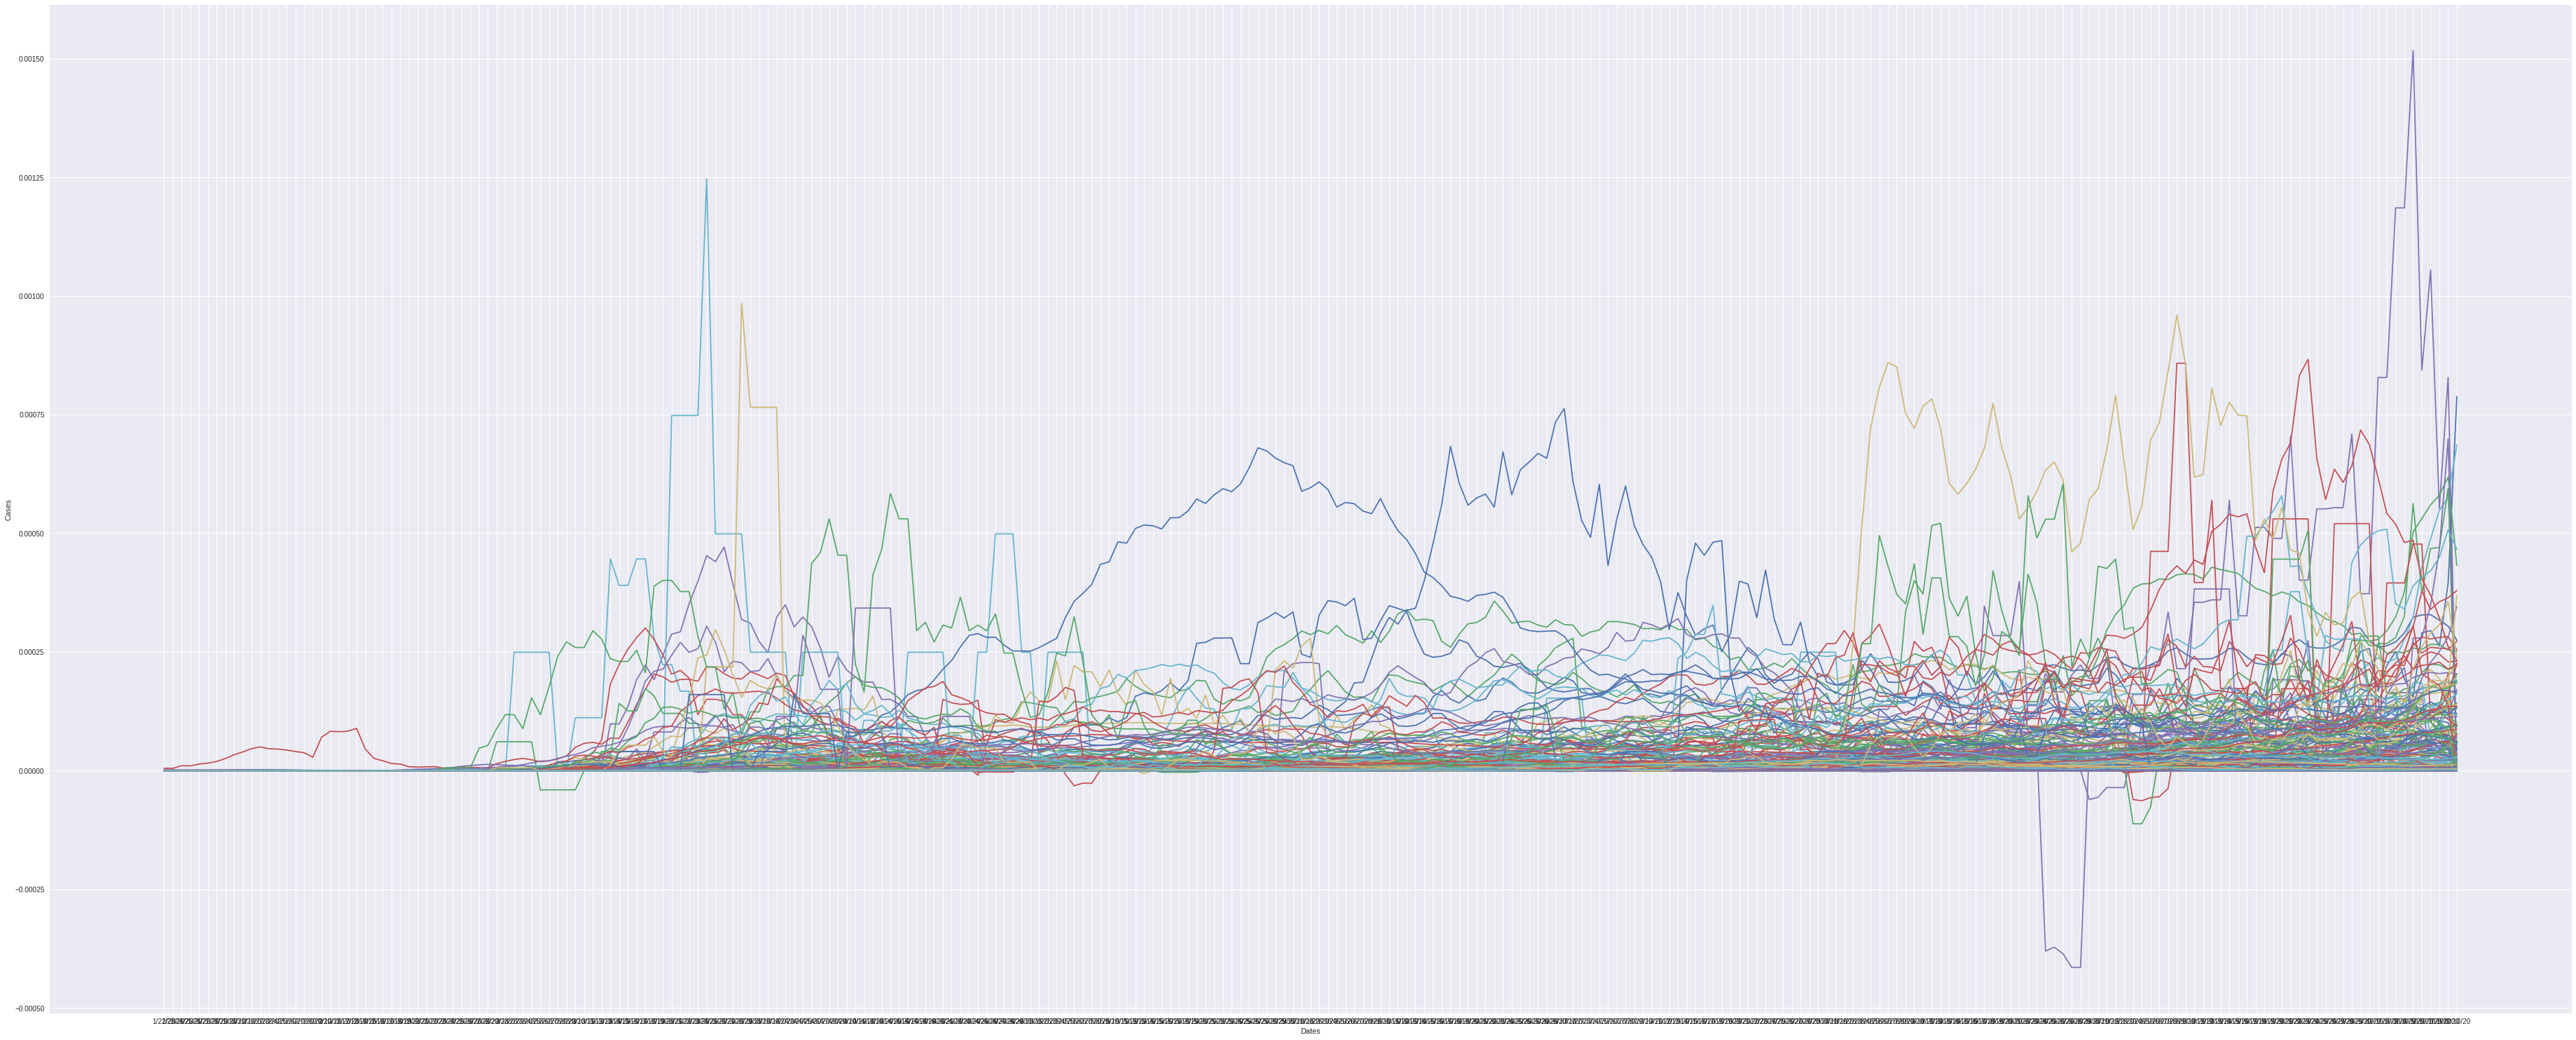

In [ ]:
def get_graphs(df, areas=['no province Philippines']):
  fig=plt.figure(figsize=(50,20))
  ax=fig.add_axes([0,0,1,1])
  ax.set_xlabel("Dates")
  ax.set_ylabel("Cases")
  for area in areas:
    try:
        df_area = df[df['area'] == area]
        x = df_area.columns[6:]
        y=[]
        for i in x:
          y.append(df_area[i].values.sum())
        
        ax.plot(x,y,label=area)
        #comment out the line below to remove the labels of the area names.
        #ax.legend()
    except IndexError:
        # No South Korea in the dataset
        print("area is not in the dataset")
        
get_graphs(moved_scaled, areas=moved_scaled['area'])

In [ ]:
# Single country
def get_graph(df, country='Philippines', index=None):
  try:
    if index:
      df_country = df.loc[index]
    else:
      df_country = df[df['Country/Region'] == country]
    x = df_country.columns[6:]
    y=[]
    for i in x:
      y.append(df_country[i].values.sum())
  
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    fig.suptitle(df_country['area'].values[0], fontsize=16)
    ax.set_xlabel("Dates")
    ax.set_ylabel("Cases")
    #ax.get_xaxis().set_ticks([])
    #ax.get_yaxis().set_ticks([])
    ax.plot(x,y)
  except IndexError:
    # No South Korea in the dataset
    print("Country is not in the dataset")

In [ ]:
import math

# Multiple countries
def compare_graphs(df, range_of_index=(0,10), num_rows=4, figsize=(10,10)):
  start_index = range_of_index[0]
  end_index = range_of_index[1]
  df_country = df.loc[start_index:end_index]
  num_cols = math.ceil(df_country.shape[0] / num_rows)

  fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
  fig.suptitle('Countries from {} to {}'.format(df_country.loc[start_index, 'area'], df_country.loc[end_index, 'area'], fontsize=16))
  x = df.columns[6:]
  ctr = 0

  for i in range(num_rows):
    for j in range(num_cols):
      if start_index + ctr <= end_index:
        try:
          curr_country = df_country.loc[start_index + ctr]
          y = [curr_country[i] for i in x]
          axs[i, j].plot(x, y)
          axs[i, j].set_title(curr_country['area'])
          axs[i, j].get_xaxis().set_ticks([])
          axs[i, j].get_yaxis().set_ticks([])
          ctr += 1
        except KeyError:
          axs[i, j].axis('off')
      else:
        axs[i, j].axis('off')

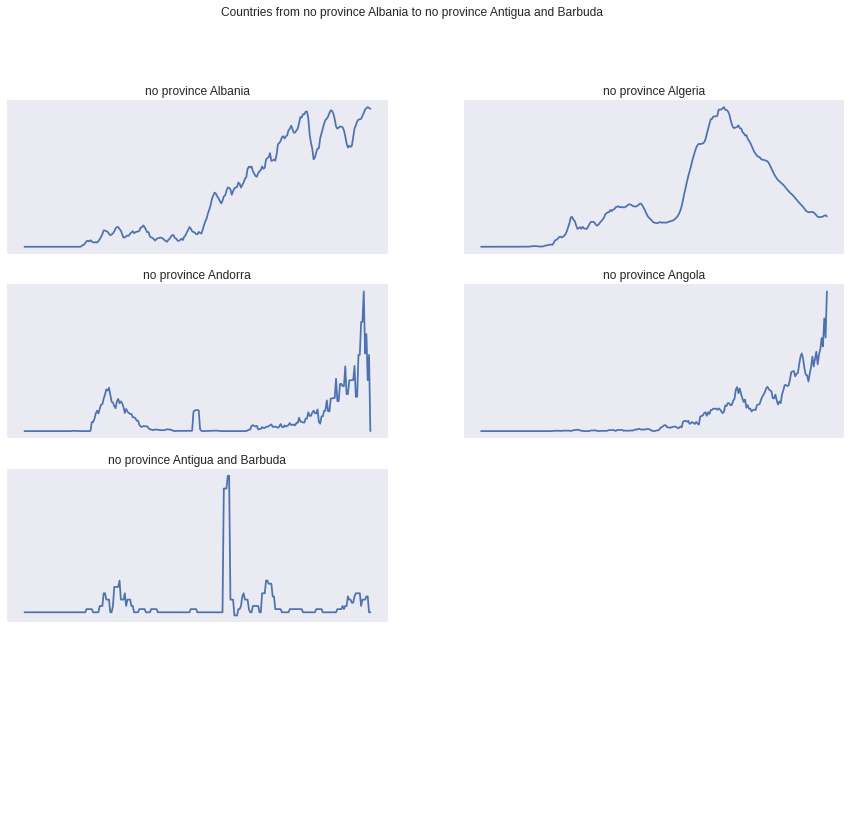

In [ ]:
compare_graphs(moved_scaled, range_of_index=(1,5), figsize=(15,13))

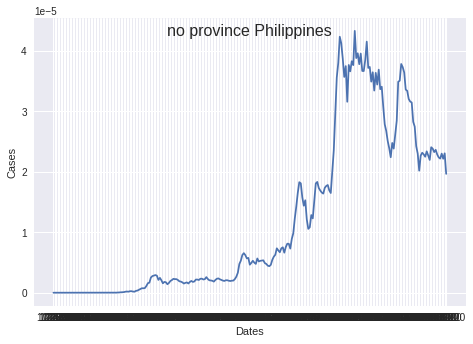

In [ ]:
get_graph(moved_scaled, country='Philippines')

# Smoothing Curves

In [ ]:
new_dates = moved_scaled.columns[6:]

In [ ]:
new_moved_scaled = moved_scaled.copy()
new_moved_scaled = new_moved_scaled[(new_moved_scaled[new_dates]>=0).all(axis=1)]

In [ ]:
new_moved_scaled.head()

Province/State Country/Region       Lat  ...   10/8/20   10/9/20      10/10/20
0    no province    Afghanistan  33.93911  ...  0.000001  0.000001  2.568822e-07
1    no province        Albania  41.15330  ...  0.000058  0.000058  5.733552e-05
2    no province        Algeria  28.03390  ...  0.000003  0.000003  3.101408e-06
3    no province        Andorra  42.50630  ...  0.000552  0.000828  0.000000e+00
4    no province         Angola -11.20270  ...  0.000005  0.000004  6.541661e-06

[5 rows x 269 columns]

In [ ]:
new_moved_scaled.shape

(236, 269)

### Stack 7-day moving average for 5 times on all countries

In [ ]:
def Moving_Ave_Stack(dff, days, times):
    NUM_DAYS = days
    new_dff = dff.copy()
    if times>0:
        
        dates = new_dff.columns[6:]
        for idx, date in enumerate(dates):
            seven_days = dates[idx : idx+NUM_DAYS]
            new_dff[date] = new_dff.apply(lambda x: x[seven_days].mean(), axis=1)
        times=times-1
        return Moving_Ave_Stack(new_dff, days, times)
    else:
        return new_dff

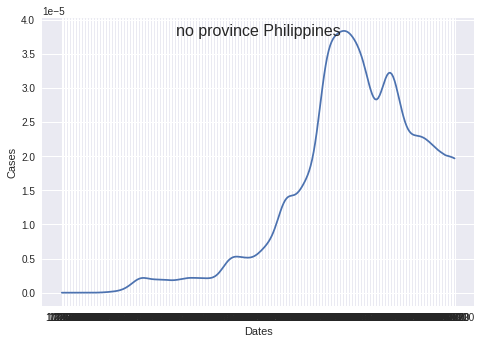

In [ ]:
smoothen_moved_scaled = Moving_Ave_Stack(new_moved_scaled, 7, 5)
get_graph(smoothen_moved_scaled, country='Philippines')

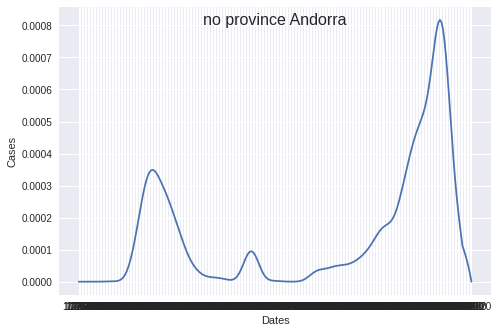

In [ ]:
get_graph(smoothen_moved_scaled, country='Andorra')

In [ ]:
c1=moved_scaled['Country/Region']
c2=new_moved_scaled['Country/Region']
set(c1)-set(c2)

{'Antigua and Barbuda',
 'Benin',
 'Ecuador',
 'Guyana',
 'Jordan',
 'Lithuania',
 'Luxembourg',
 'Madagascar',
 'Mauritius',
 'Monaco',
 'Niger',
 'San Marino',
 'Spain',
 'Uganda',
 'Uruguay',
 'Zimbabwe'}

In [ ]:
smoothen_moved_scaled.head()

Province/State Country/Region  ...       10/9/20      10/10/20
0    no province    Afghanistan  ...  2.837746e-07  2.568822e-07
1    no province        Albania  ...  5.734638e-05  5.733552e-05
2    no province        Algeria  ...  3.104972e-06  3.101408e-06
3    no province        Andorra  ...  2.588494e-05  0.000000e+00
4    no province         Angola  ...  6.474152e-06  6.541661e-06

[5 rows x 269 columns]

In [ ]:
get_graphs(smoothen_moved_scaled, areas=smoothen_moved_scaled['area'])

Output hidden; open in https://colab.research.google.com to view.

**Shift Thresholds**

low < 0.0001

mid 0.0001 to 0.0003

high > 0.0003

In [ ]:
shifts = [[] for i in range(236)]
lows=0.0001
mids=0.0003

In [ ]:
rown=0
for i in smoothen_moved_scaled.iterrows():
    cur_tmp='low'
    next_tmp='low'
    same_counter=15
    for j in range(6,269):
        if i[1][j]<lows:
            next_tmp='low'
        elif i[1][j]<mids:
            next_tmp='mid'
        else:
            next_tmp='high'
        if cur_tmp==next_tmp:
            same_counter=same_counter+1
            if same_counter>=15:
                shifts[rown].append(next_tmp)
                cur_tmp=next_tmp
                same_counter=0
        else:
            same_counter=0
            shifts[rown].append(next_tmp)
            cur_tmp=next_tmp
            same_counter=0
    rown=rown+1
    

In [ ]:
vector_shifts=[[] for i in range(236)]
shift_change = {'lowlow':0, 'lowmid':1, 'midlow':2, 'midmid':3, 'midhigh':4, 'highmid':5, 'highhigh':6}

In [ ]:
for i in range(0, 236):
    for j in range(1, len(shifts[i])):
        vector_shifts[i].append(shift_change[shifts[i][j-1]+shifts[i][j]])

In [ ]:
number_of_shifts = [len(i) for i in shifts]

In [ ]:
number_of_shifts_added = smoothen_moved_scaled.copy()
number_of_shifts_added['shifts']=number_of_shifts
number_of_shifts_added.head()

Province/State Country/Region       Lat  ...       10/9/20      10/10/20 shifts
0    no province    Afghanistan  33.93911  ...  2.837746e-07  2.568822e-07     18
1    no province        Albania  41.15330  ...  5.734638e-05  5.733552e-05     18
2    no province        Algeria  28.03390  ...  3.104972e-06  3.101408e-06     18
3    no province        Andorra  42.50630  ...  2.588494e-05  0.000000e+00     22
4    no province         Angola -11.20270  ...  6.474152e-06  6.541661e-06     18

[5 rows x 270 columns]

In [ ]:
for i in vector_shifts:
    while(len(i))<22:
        i.append(-1)


In [ ]:
shifts_added = number_of_shifts_added.copy()
for i in range(1, 23):
    name='shift '+str(i)
    tmp=[]
    for j in vector_shifts:
        tmp.append(j[i-1])
    shifts_added[name]=tmp
shifts_added.head()

Province/State Country/Region       Lat  ...  shift 20  shift 21 shift 22
0    no province    Afghanistan  33.93911  ...        -1        -1       -1
1    no province        Albania  41.15330  ...        -1        -1       -1
2    no province        Algeria  28.03390  ...        -1        -1       -1
3    no province        Andorra  42.50630  ...         5         2       -1
4    no province         Angola -11.20270  ...        -1        -1       -1

[5 rows x 292 columns]

In [ ]:
#shifts_added.to_csv(os.path.join(BASE_DIR, 'confirmed_added_features.csv'))

## Deaths

In [ ]:
file_path = os.path.join(BASE_DIR, 'data/time_series_covid19_deaths_global.csv')
deaths = pd.read_csv(file_path)
deaths.head()

Province/State Country/Region       Lat  ...  10/9/20  10/10/20  10/11/20
0            NaN    Afghanistan  33.93911  ...     1472      1473      1477
1            NaN        Albania  41.15330  ...      413       416       420
2            NaN        Algeria  28.03390  ...     1789      1795      1801
3            NaN        Andorra  42.50630  ...       55        55        55
4            NaN         Angola -11.20270  ...      212       218       218

[5 rows x 268 columns]

In [ ]:
deaths['population']=tmp2

In [ ]:
# Rearrange columns to put population before the dates
cols = deaths.columns.tolist()
cols = cols[:4] + cols[-1::] + cols[4:-1]
deaths = deaths[cols]
deaths.head()

Province/State Country/Region       Lat  ...  10/9/20  10/10/20  10/11/20
0            NaN    Afghanistan  33.93911  ...     1472      1473      1477
1            NaN        Albania  41.15330  ...      413       416       420
2            NaN        Algeria  28.03390  ...     1789      1795      1801
3            NaN        Andorra  42.50630  ...       55        55        55
4            NaN         Angola -11.20270  ...      212       218       218

[5 rows x 269 columns]

In [ ]:
columns = deaths.columns

In [ ]:
# Copies the specified columns into a new Dataframe
daily_deaths = deaths.copy()
print(len(columns))

for i in range(7, len(columns)):
    daily = deaths[columns[i]] - deaths[columns[i-1]]
    daily_deaths[columns[i]]=daily

daily_deaths.head()

269


Province/State Country/Region       Lat  ...  10/9/20  10/10/20  10/11/20
0            NaN    Afghanistan  33.93911  ...        2         1         4
1            NaN        Albania  41.15330  ...        2         3         4
2            NaN        Algeria  28.03390  ...        6         6         6
3            NaN        Andorra  42.50630  ...        1         0         0
4            NaN         Angola -11.20270  ...        4         6         0

[5 rows x 269 columns]

In [ ]:
NUM_DAYS = 5
moving_ave_deaths = daily_deaths.copy()

In [ ]:
dates = columns[5:]

for idx, date in enumerate(dates):
  seven_days = dates[idx : idx+NUM_DAYS]
  moving_ave_deaths[date] = daily_deaths.apply(lambda x: x[seven_days].mean(), axis=1)

moving_ave_deaths.head()

Province/State Country/Region       Lat  ...   10/9/20  10/10/20  10/11/20
0            NaN    Afghanistan  33.93911  ...  2.333333       2.5       4.0
1            NaN        Albania  41.15330  ...  3.000000       3.5       4.0
2            NaN        Algeria  28.03390  ...  6.000000       6.0       6.0
3            NaN        Andorra  42.50630  ...  0.333333       0.0       0.0
4            NaN         Angola -11.20270  ...  3.333333       3.0       0.0

[5 rows x 269 columns]

In [ ]:
# Combine province/state and country into one column
moving_ave_deaths['Province/State']=moving_ave_deaths['Province/State'].fillna("no province")
moving_ave_deaths['area']=moving_ave_deaths['Province/State']+" "+moving_ave_deaths['Country/Region']
moving_ave_deaths.head()

Province/State Country/Region  ...  10/11/20                     area
0    no province    Afghanistan  ...       4.0  no province Afghanistan
1    no province        Albania  ...       4.0      no province Albania
2    no province        Algeria  ...       6.0      no province Algeria
3    no province        Andorra  ...       0.0      no province Andorra
4    no province         Angola  ...       0.0       no province Angola

[5 rows x 270 columns]

In [ ]:
scaled_deaths = moving_ave_deaths.copy()
cols = scaled_deaths.columns.tolist()
cols = cols[:5] + cols[-1::] + cols[5:-1]
scaled_deaths = scaled_deaths[cols]
scaled_deaths.head()

Province/State Country/Region       Lat  ...   10/9/20  10/10/20 10/11/20
0    no province    Afghanistan  33.93911  ...  2.333333       2.5      4.0
1    no province        Albania  41.15330  ...  3.000000       3.5      4.0
2    no province        Algeria  28.03390  ...  6.000000       6.0      6.0
3    no province        Andorra  42.50630  ...  0.333333       0.0      0.0
4    no province         Angola -11.20270  ...  3.333333       3.0      0.0

[5 rows x 270 columns]

In [ ]:
daily_columns = scaled_deaths.columns[6:]
for col in daily_columns:
  scaled_deaths[col] = scaled_deaths[col] / scaled_deaths['population']

scaled_deaths.head()

Province/State Country/Region  ...      10/10/20      10/11/20
0    no province    Afghanistan  ...  6.422056e-08  1.027529e-07
1    no province        Albania  ...  1.216208e-06  1.389952e-06
2    no province        Algeria  ...  1.368268e-07  1.368268e-07
3    no province        Andorra  ...  0.000000e+00  0.000000e+00
4    no province         Angola  ...  9.127899e-08  0.000000e+00

[5 rows x 270 columns]

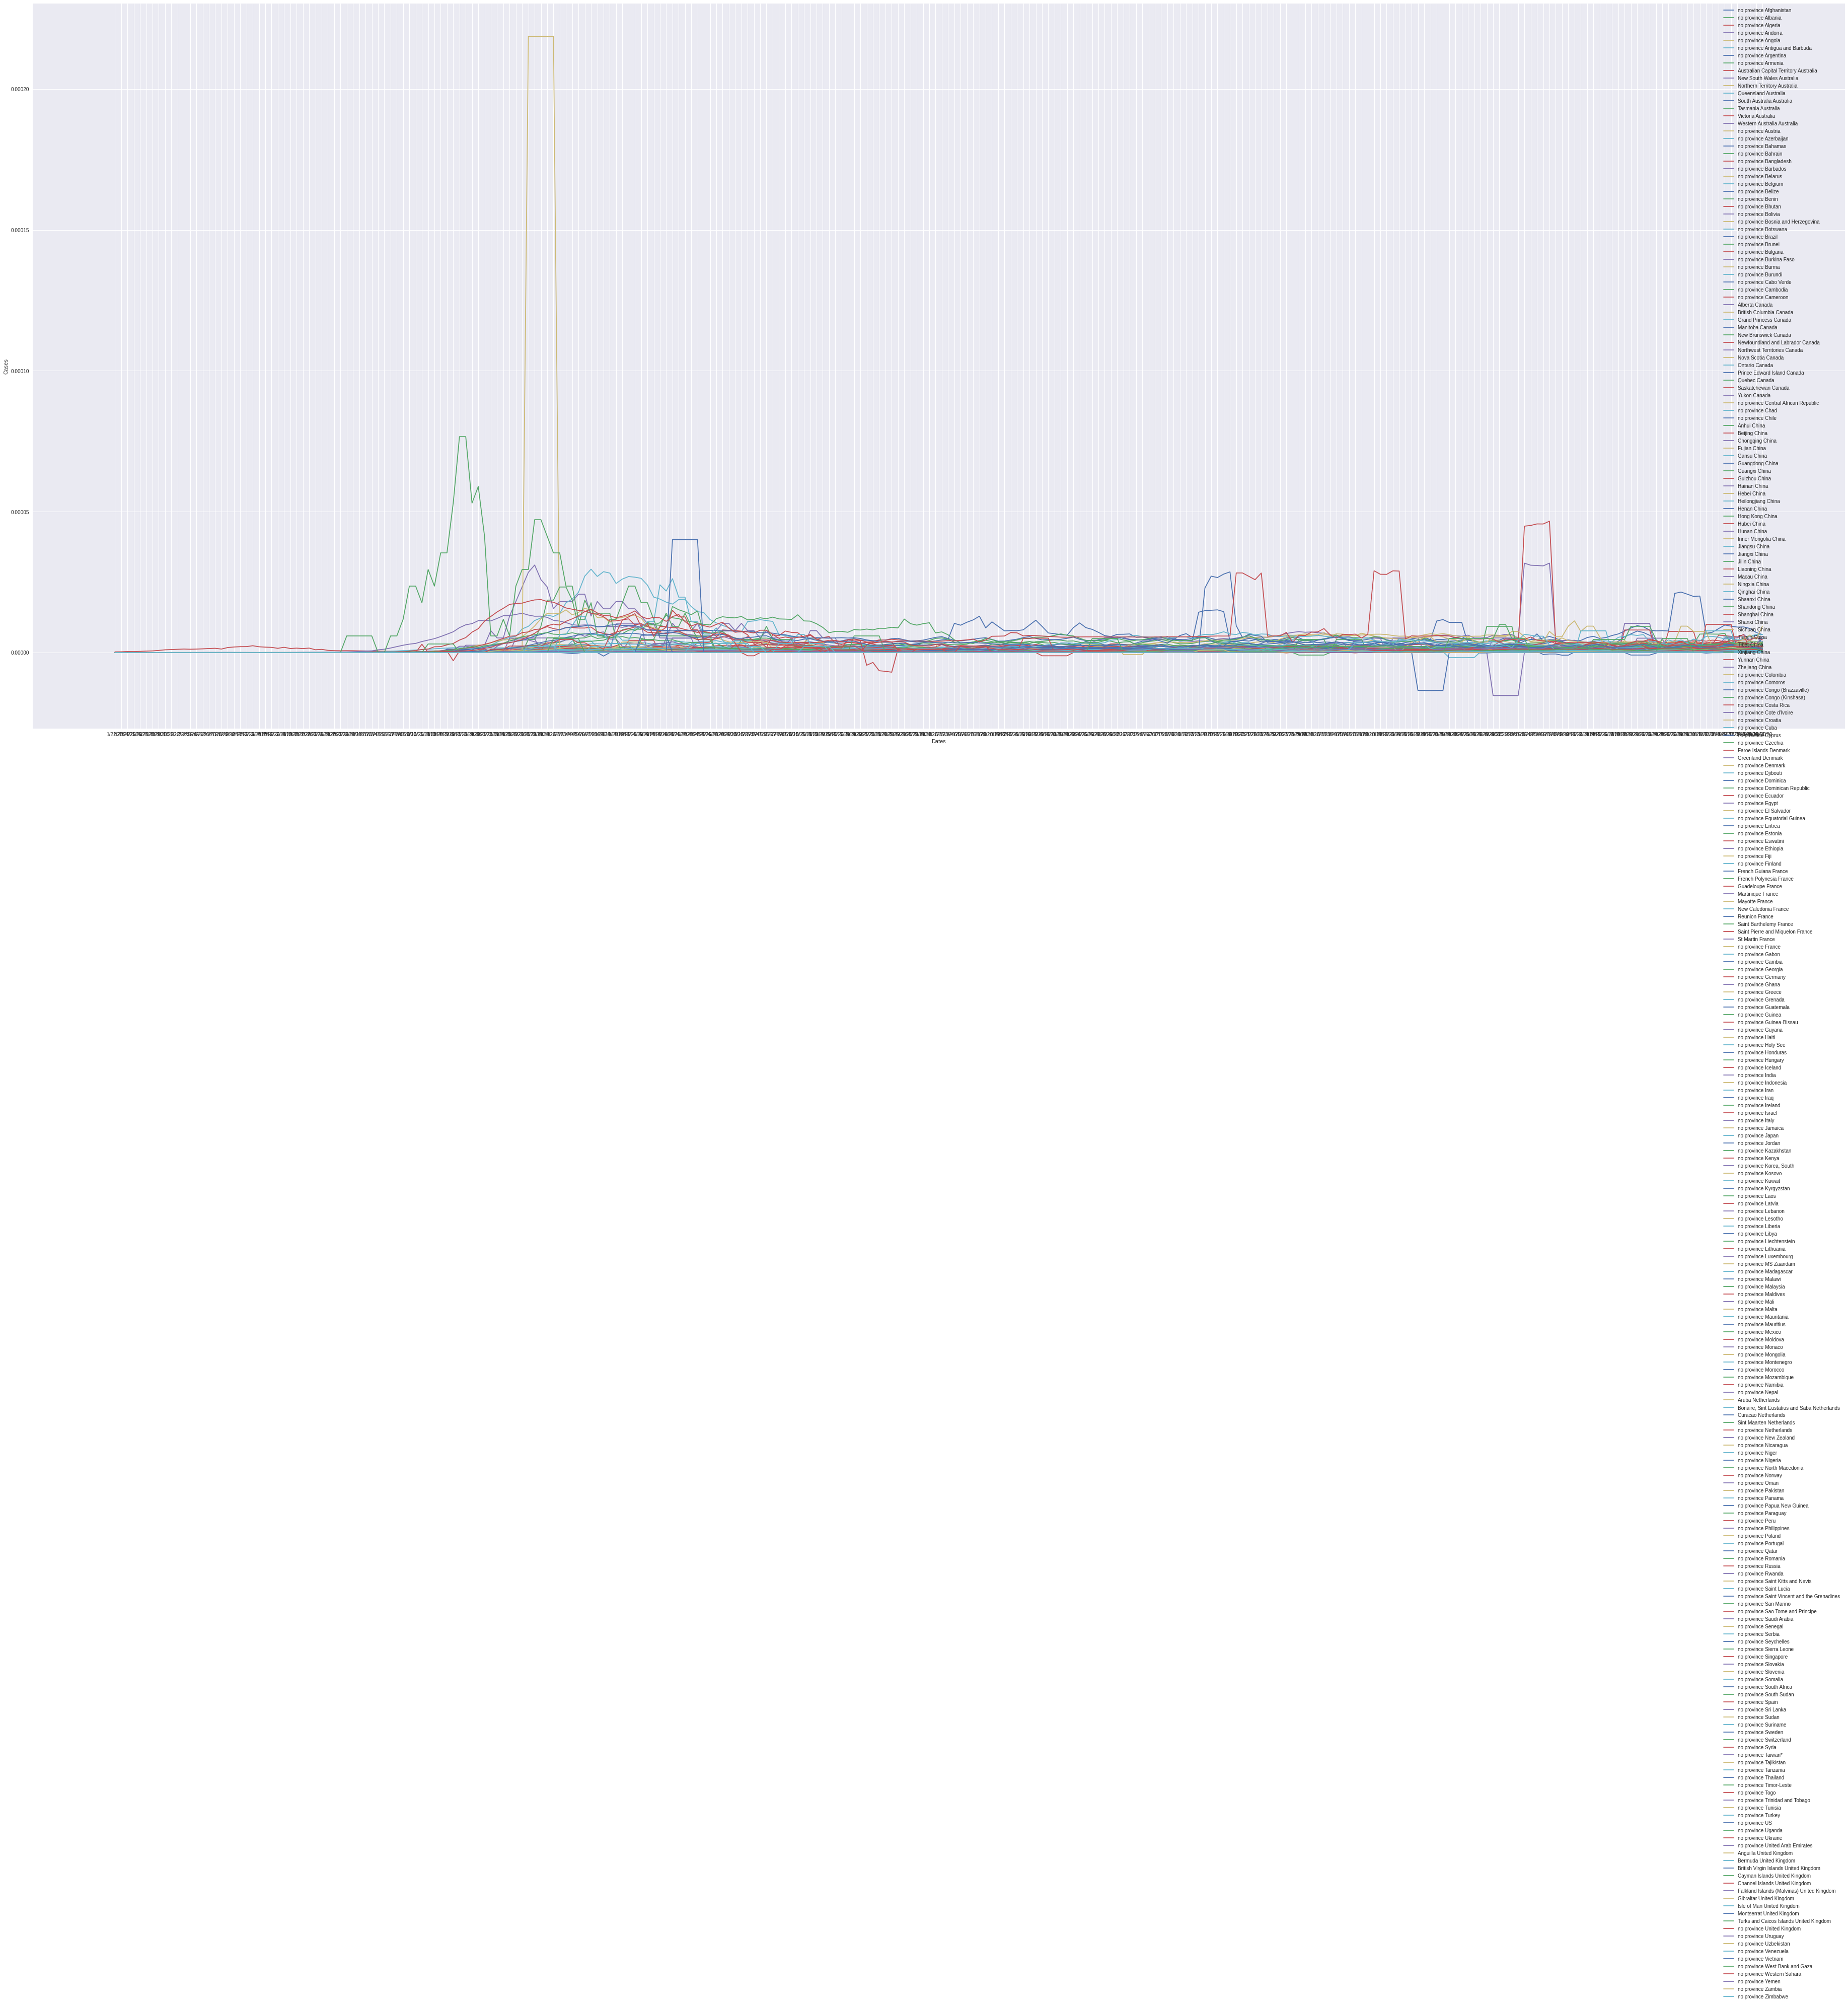

In [ ]:
scaled_deaths = scaled_deaths[~scaled_deaths.area.str.contains("Diamond Princess")]
get_graphs(scaled_deaths, areas=scaled_deaths['area'])

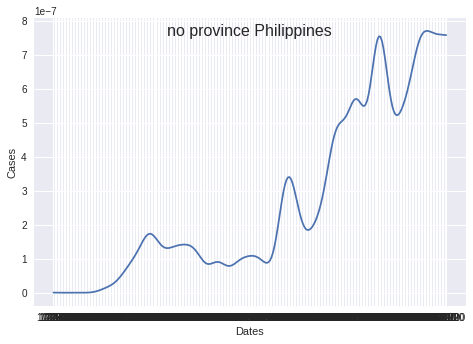

In [ ]:
smoothen_scaled_deaths = Moving_Ave_Stack(scaled_deaths, 7, 5)
get_graph(smoothen_scaled_deaths, country='Philippines')

In [ ]:
smoothen_scaled_deaths.shape

(264, 270)

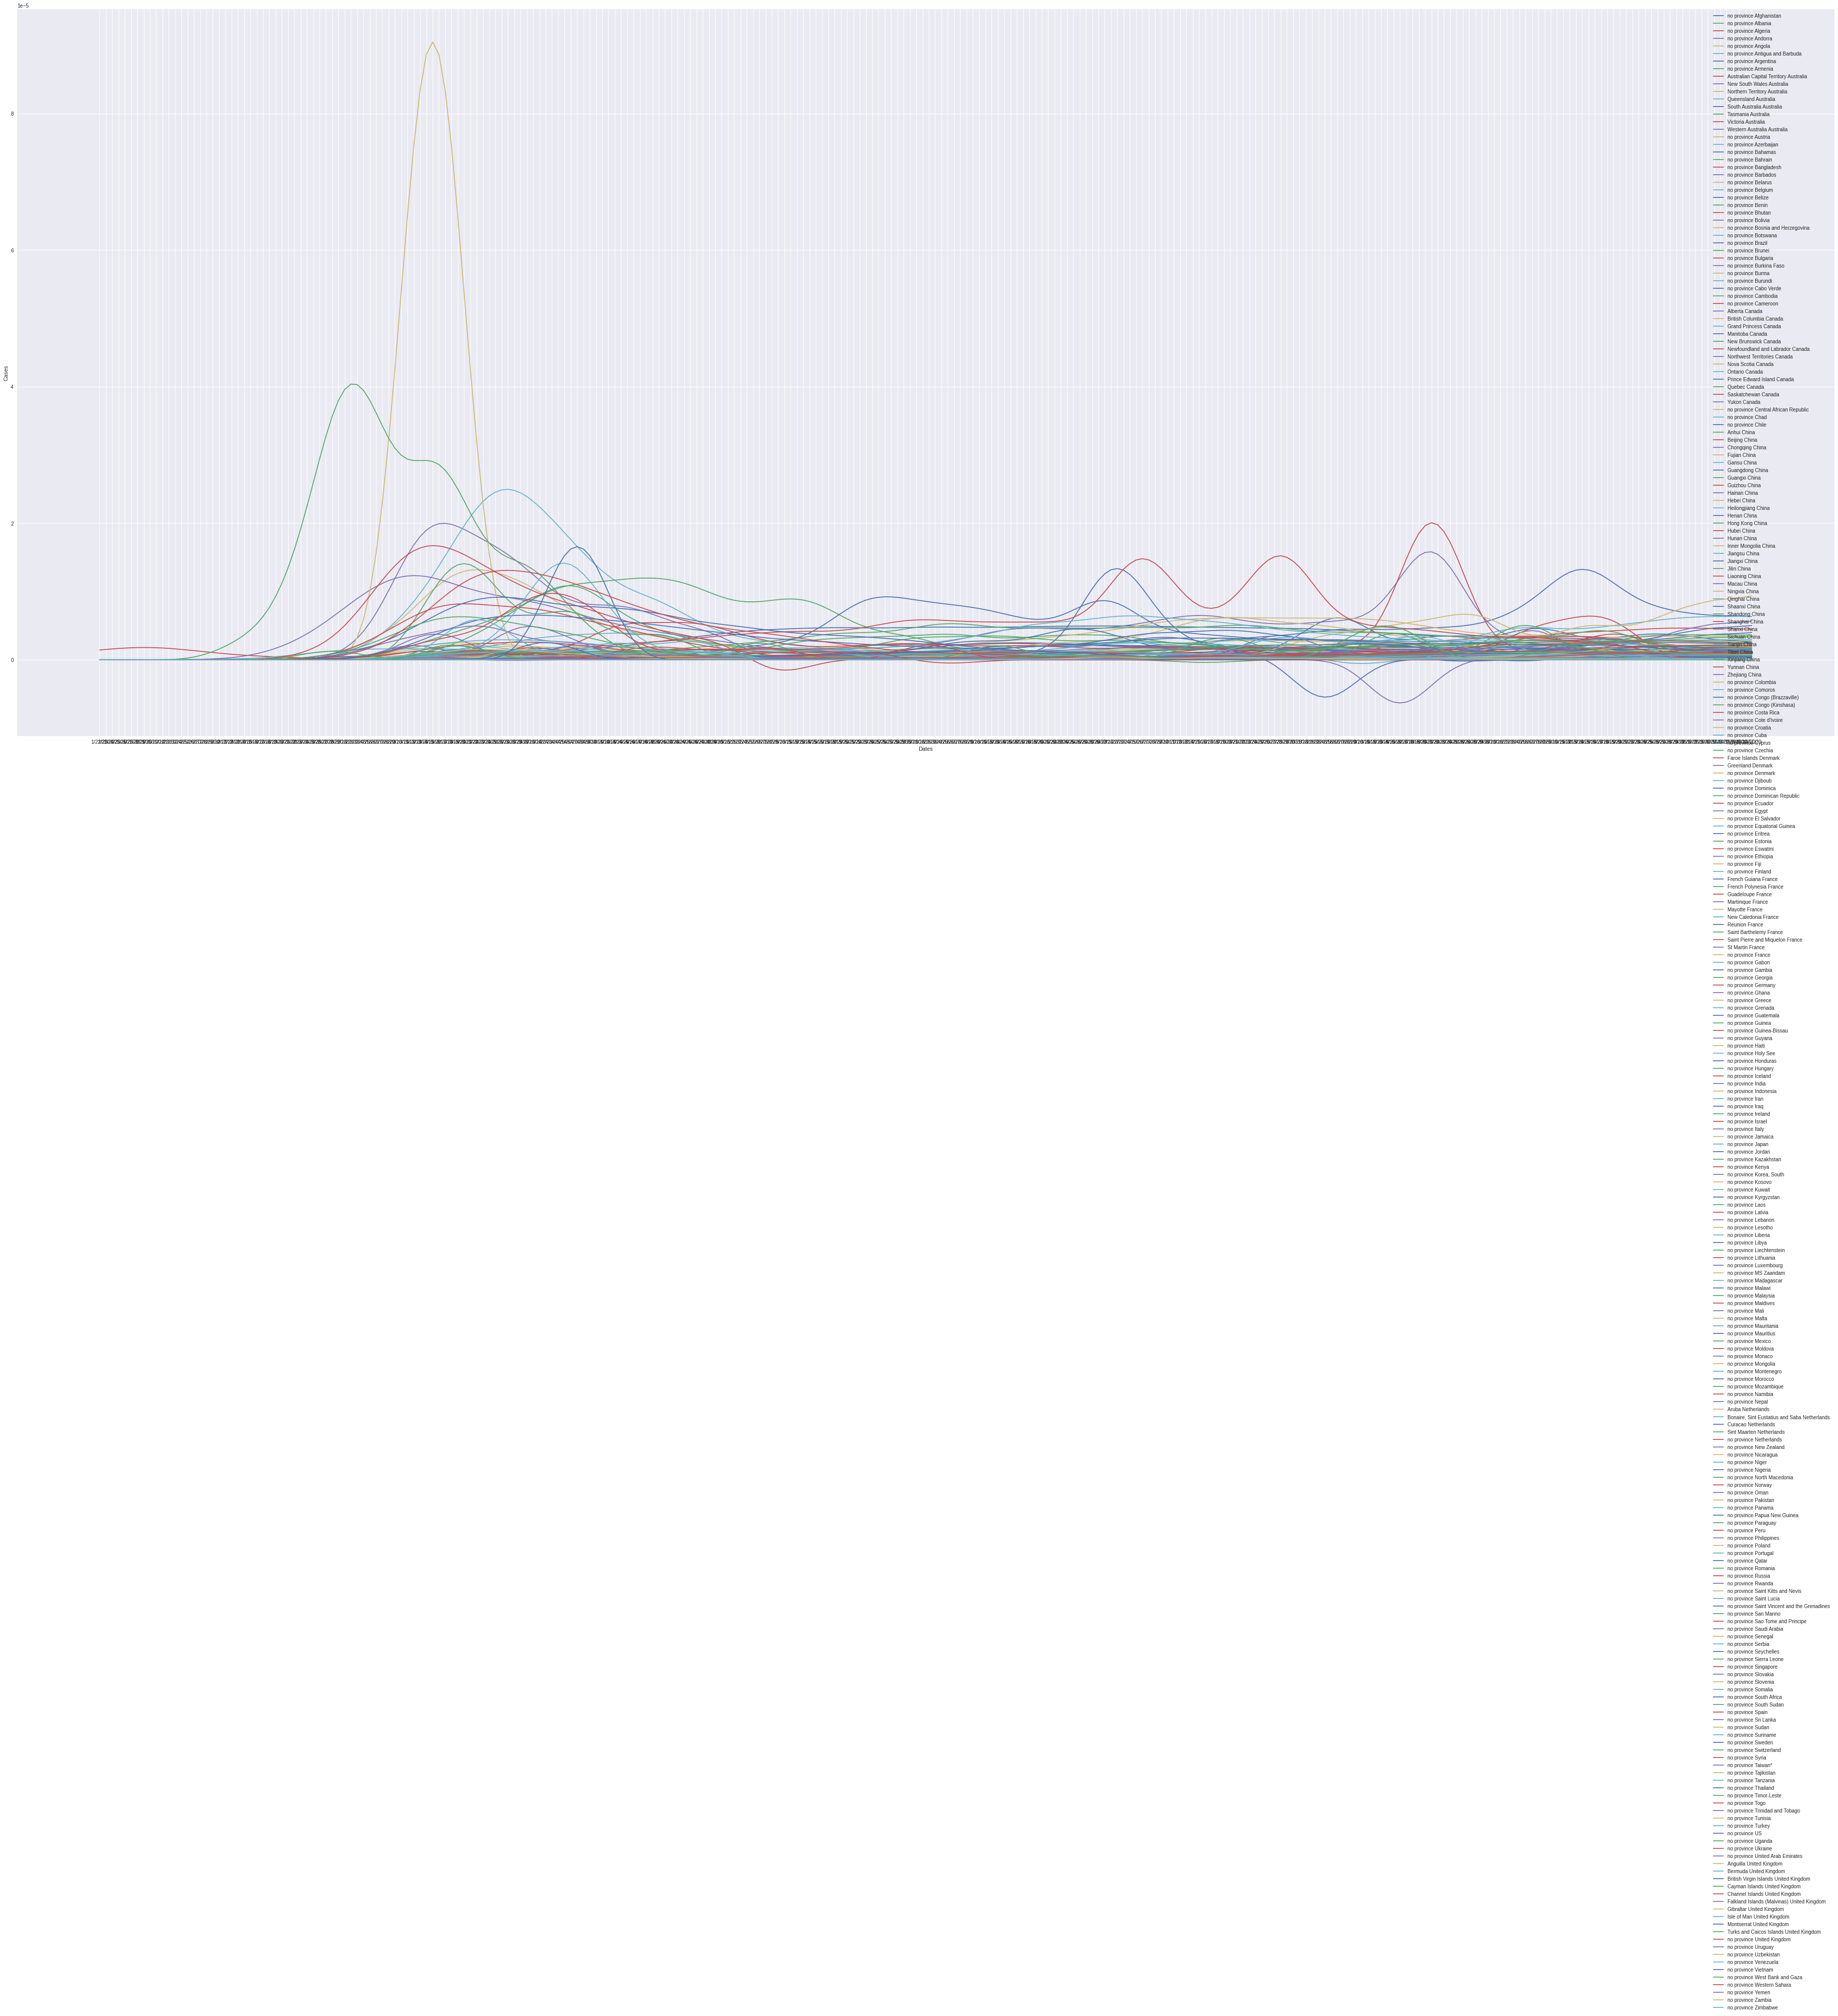

In [ ]:
get_graphs(smoothen_scaled_deaths, areas=smoothen_scaled_deaths['area'])

In [ ]:
shifts = [[] for i in range(264)]
lows=0.0000025
mids=0.00001

In [ ]:
rown=0
for i in smoothen_scaled_deaths.iterrows():
    cur_tmp='low'
    next_tmp='low'
    same_counter=15
    for j in range(6,270):
        if i[1][j]<lows:
            next_tmp='low'
        elif i[1][j]<mids:
            next_tmp='mid'
        else:
            next_tmp='high'
        if cur_tmp==next_tmp:
            same_counter=same_counter+1
            if same_counter>=15:
                shifts[rown].append(next_tmp)
                cur_tmp=next_tmp
                same_counter=0
        else:
            same_counter=0
            shifts[rown].append(next_tmp)
            cur_tmp=next_tmp
            same_counter=0
    rown=rown+1

In [ ]:
vector_shifts=[[] for i in range(264)]
shift_change = {'lowlow':0, 'lowmid':1, 'midlow':2, 'midmid':3, 'midhigh':4, 'highmid':5, 'highhigh':6}

In [ ]:
for i in range(0, 264):
    for j in range(1, len(shifts[i])):
        vector_shifts[i].append(shift_change[shifts[i][j-1]+shifts[i][j]])

In [ ]:
number_of_shifts = [len(i) for i in shifts]

In [ ]:
number_of_shifts_added = smoothen_scaled_deaths.copy()
number_of_shifts_added['shifts']=number_of_shifts
number_of_shifts_added.head()

Province/State Country/Region       Lat  ...      10/10/20      10/11/20 shifts
0    no province    Afghanistan  33.93911  ...  1.015488e-07  1.027529e-07     18
1    no province        Albania  41.15330  ...  1.384523e-06  1.389952e-06     18
2    no province        Algeria  28.03390  ...  1.368268e-07  1.368268e-07     18
3    no province        Andorra  42.50630  ...  0.000000e+00  0.000000e+00     21
4    no province         Angola -11.20270  ...  2.852468e-09  0.000000e+00     18

[5 rows x 271 columns]

In [ ]:
for i in vector_shifts:
    while(len(i))<23:
        i.append(-1)

In [ ]:
shifts_added = number_of_shifts_added.copy()
for i in range(1, 24):
    name='shift '+str(i)
    tmp=[]
    for j in vector_shifts:
        tmp.append(j[i-1])
    shifts_added[name]=tmp
shifts_added.head()

Province/State Country/Region       Lat  ...  shift 21  shift 22 shift 23
0    no province    Afghanistan  33.93911  ...        -1        -1       -1
1    no province        Albania  41.15330  ...        -1        -1       -1
2    no province        Algeria  28.03390  ...        -1        -1       -1
3    no province        Andorra  42.50630  ...        -1        -1       -1
4    no province         Angola -11.20270  ...        -1        -1       -1

[5 rows x 294 columns]

In [ ]:
#shifts_added.to_csv(os.path.join(BASE_DIR, 'deaths_added_features.csv'))

## Recoveries

In [ ]:
file_path = os.path.join(BASE_DIR, 'time_series_covid19_recovered_global.csv')
recovered = pd.read_csv(file_path)
recovered.head()

Province/State Country/Region       Lat  ...  10/9/20 10/10/20  10/11/20
0            NaN    Afghanistan  33.93911  ...    33058    33064     33114
1            NaN        Albania  41.15330  ...     9304     9406      9500
2            NaN        Algeria  28.03390  ...    37067    37170     37170
3            NaN        Andorra  42.50630  ...     1814     1814      1814
4            NaN         Angola -11.20270  ...     2685     2716      2743

[5 rows x 269 columns]

In [ ]:
recovered.shape

(253, 268)

In [ ]:
# Combine province/state and country into one column
recovered['Province/State']=recovered['Province/State'].fillna("no province")
recovered['area']=recovered['Province/State']+" "+recovered['Country/Region']
recovered.head()

Province/State Country/Region  ...  10/11/20                     area
0    no province    Afghanistan  ...     33114  no province Afghanistan
1    no province        Albania  ...      9500      no province Albania
2    no province        Algeria  ...     37170      no province Algeria
3    no province        Andorra  ...      1814      no province Andorra
4    no province         Angola  ...      2743       no province Angola

[5 rows x 270 columns]

In [ ]:
cols = recovered.columns.tolist()
cols = cols[:5] + cols[-1::] + cols[5:-1]
recovered = recovered[cols]
recovered.head()

Province/State Country/Region       Lat  ...  10/9/20 10/10/20 10/11/20
0    no province    Afghanistan  33.93911  ...    33058    33064    33114
1    no province        Albania  41.15330  ...     9304     9406     9500
2    no province        Algeria  28.03390  ...    37067    37170    37170
3    no province        Andorra  42.50630  ...     1814     1814     1814
4    no province         Angola -11.20270  ...     2685     2716     2743

[5 rows x 270 columns]

In [ ]:
columns = recovered.columns
# Copies the specified columns into a new Dataframe
daily_recovered = recovered.copy()
print(len(columns))

for i in range(7, len(columns)):
    daily = recovered[columns[i]] - recovered[columns[i-1]]
    daily_recovered[columns[i]]=daily

daily_recovered.head()

270


Province/State Country/Region       Lat  ...  10/9/20 10/10/20 10/11/20
0    no province    Afghanistan  33.93911  ...        0        6       50
1    no province        Albania  41.15330  ...       89      102       94
2    no province        Algeria  28.03390  ...      109      103        0
3    no province        Andorra  42.50630  ...       99        0        0
4    no province         Angola -11.20270  ...       50       31       27

[5 rows x 270 columns]

In [ ]:
NUM_DAYS = 5
moving_ave_recovered = daily_recovered.copy()
dates = columns[6:]

for idx, date in enumerate(dates):
  seven_days = dates[idx : idx+NUM_DAYS]
  moving_ave_recovered[date] = daily_recovered.apply(lambda x: x[seven_days].mean(), axis=1)

moving_ave_recovered.head()

Province/State Country/Region       Lat  ...    10/9/20 10/10/20 10/11/20
0    no province    Afghanistan  33.93911  ...  18.666667     28.0     50.0
1    no province        Albania  41.15330  ...  95.000000     98.0     94.0
2    no province        Algeria  28.03390  ...  70.666667     51.5      0.0
3    no province        Andorra  42.50630  ...  33.000000      0.0      0.0
4    no province         Angola -11.20270  ...  36.000000     29.0     27.0

[5 rows x 270 columns]

In [ ]:
tmpt=[]
for i in moving_ave_recovered['population']:
    i=str(i).replace(',','')
    tmpt.append(int(i))
moving_ave_recovered['population']=tmpt
daily_columns = moving_ave_recovered.columns[6:]
for col in daily_columns:
  moving_ave_recovered[col] = moving_ave_recovered[col] / moving_ave_recovered['population']

moving_ave_recovered.head()

Province/State Country/Region  ...      10/10/20      10/11/20
0    no province    Afghanistan  ...  7.192702e-07  1.284411e-06
1    no province        Albania  ...  3.405383e-05  3.266387e-05
2    no province        Algeria  ...  1.174430e-06  0.000000e+00
3    no province        Andorra  ...  0.000000e+00  0.000000e+00
4    no province         Angola  ...  8.823635e-07  8.215109e-07

[5 rows x 270 columns]

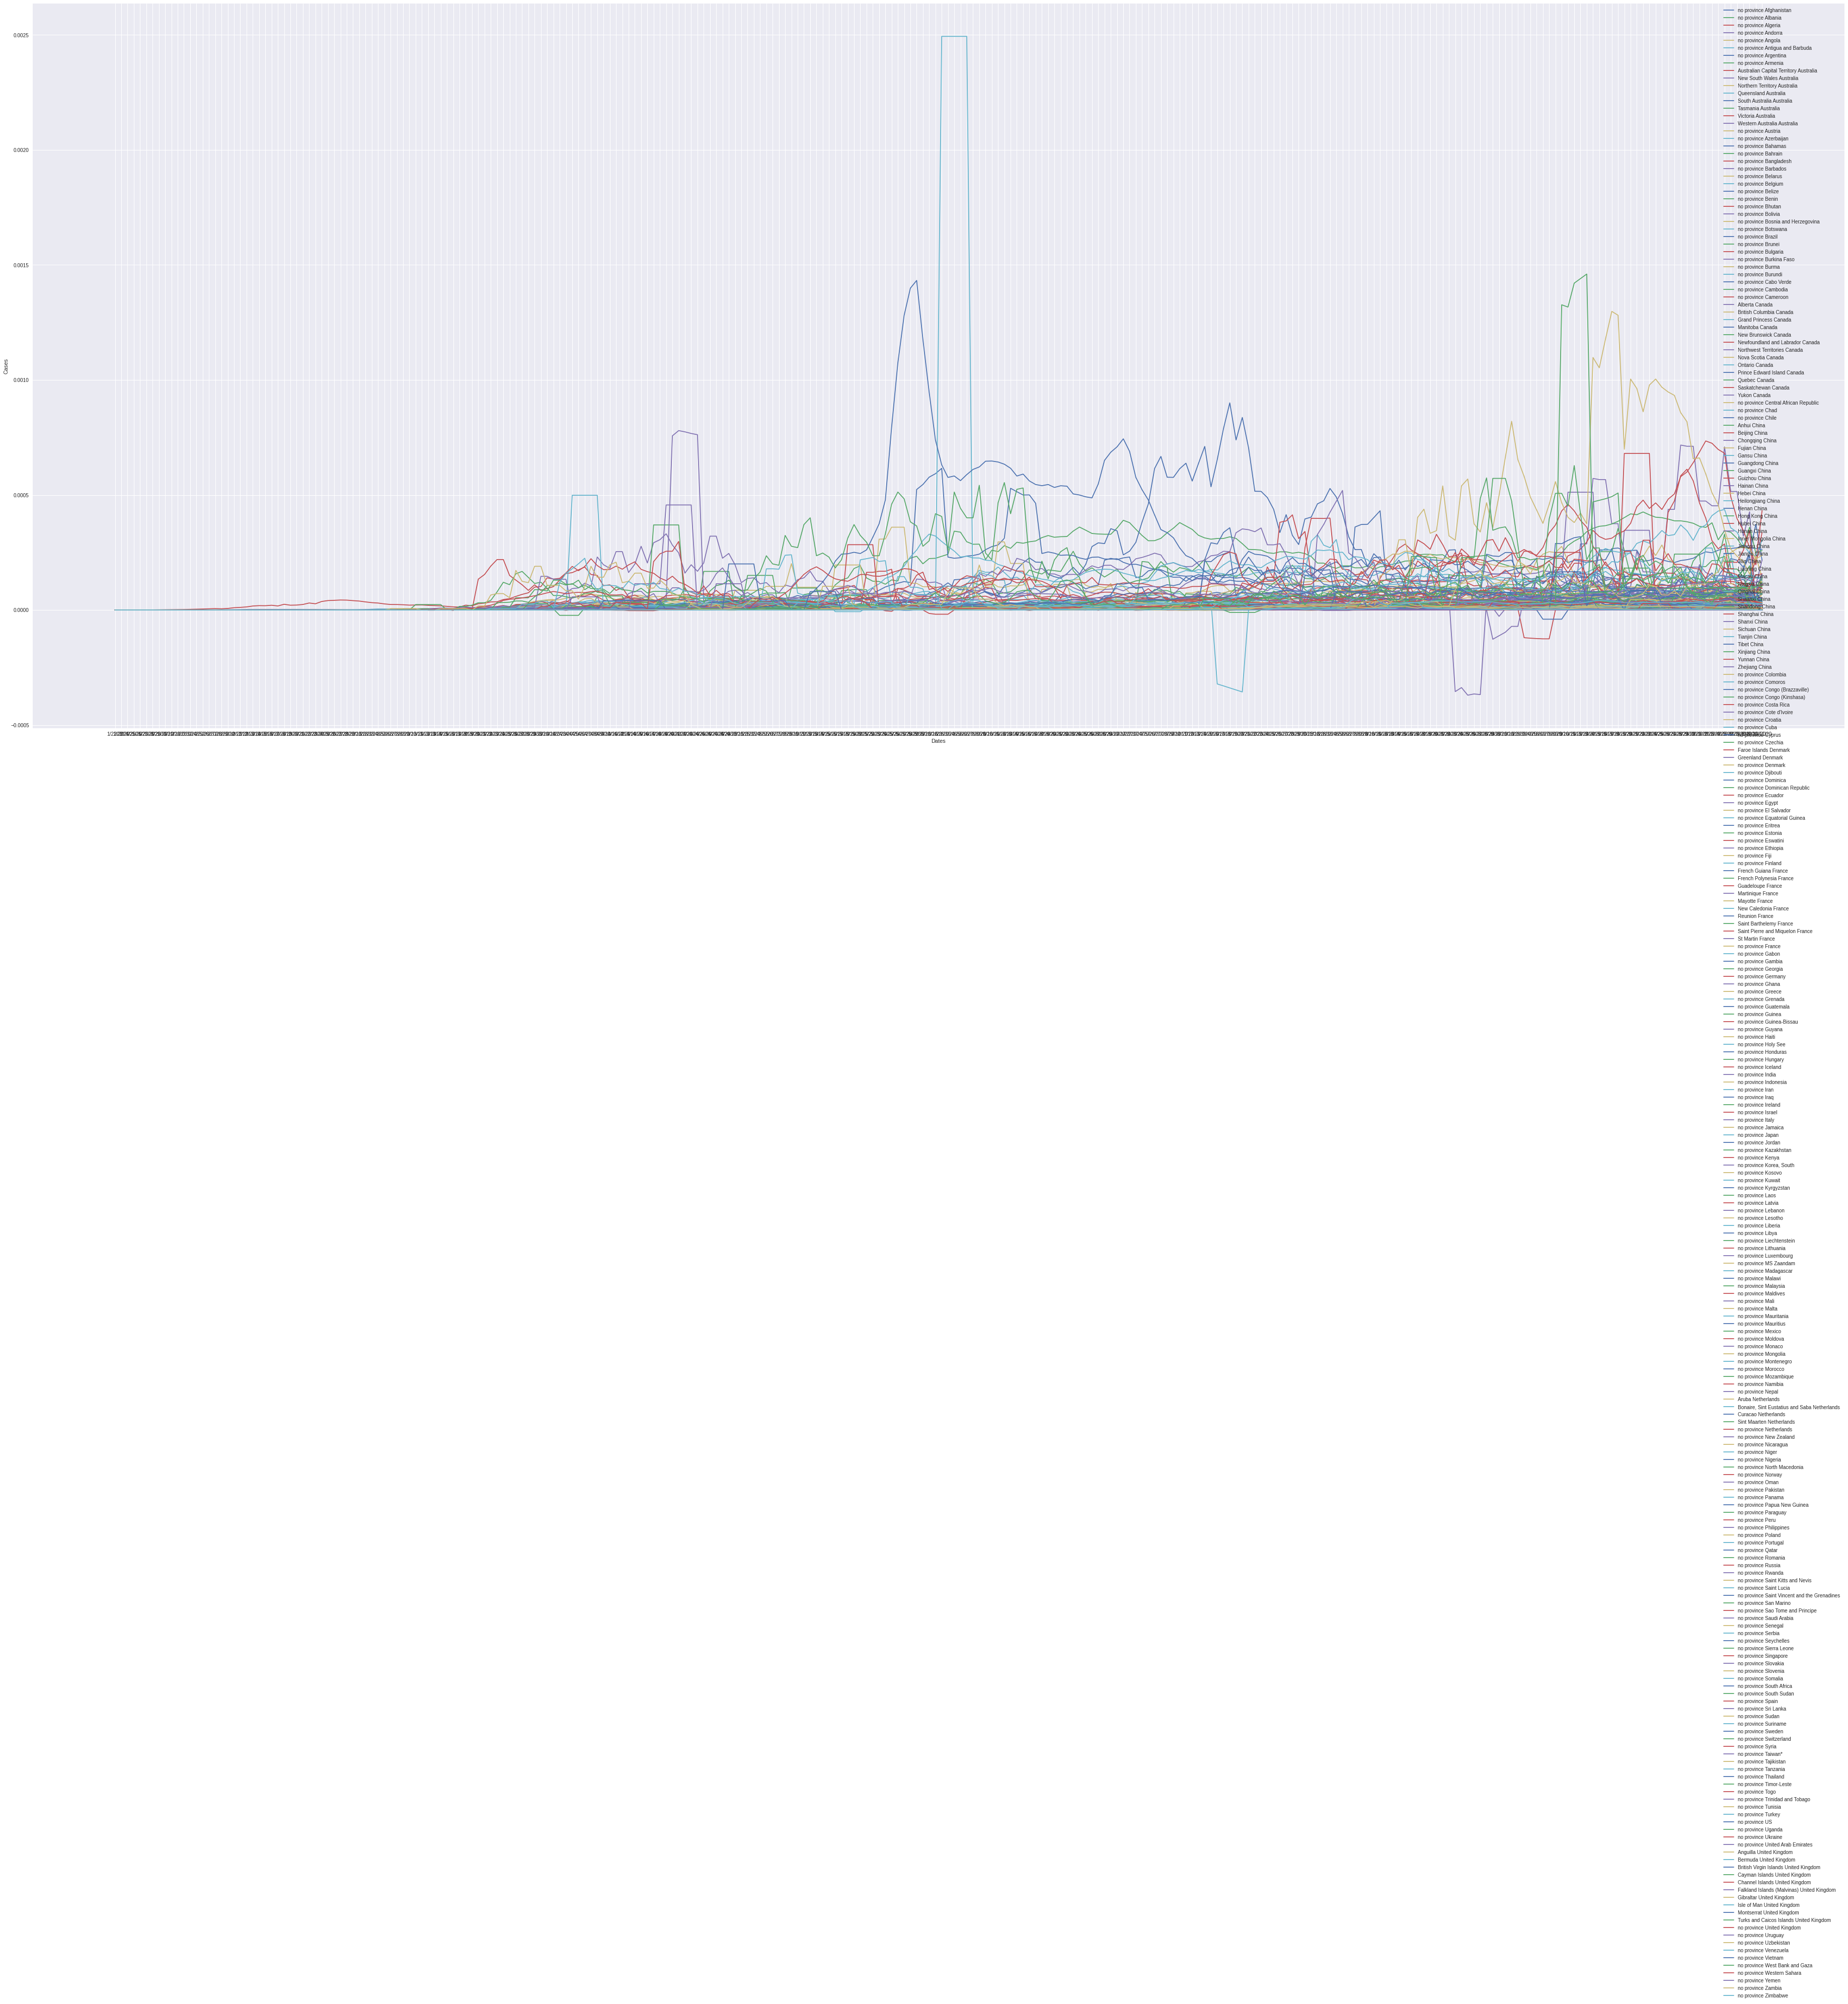

In [ ]:
moving_ave_recovered = moving_ave_recovered[~moving_ave_recovered.area.str.contains("Diamond Princess")]
get_graphs(moving_ave_recovered, areas=scaled_deaths['area'])

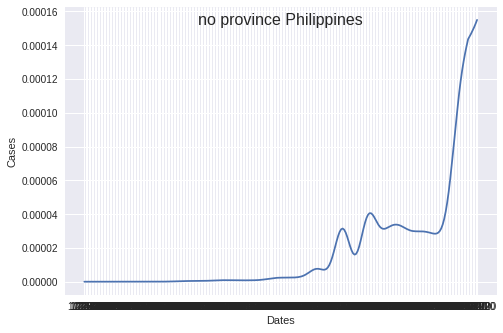

In [ ]:
smoothen_recovered = Moving_Ave_Stack(moving_ave_recovered, 7, 5)
get_graph(smoothen_recovered, country='Philippines')

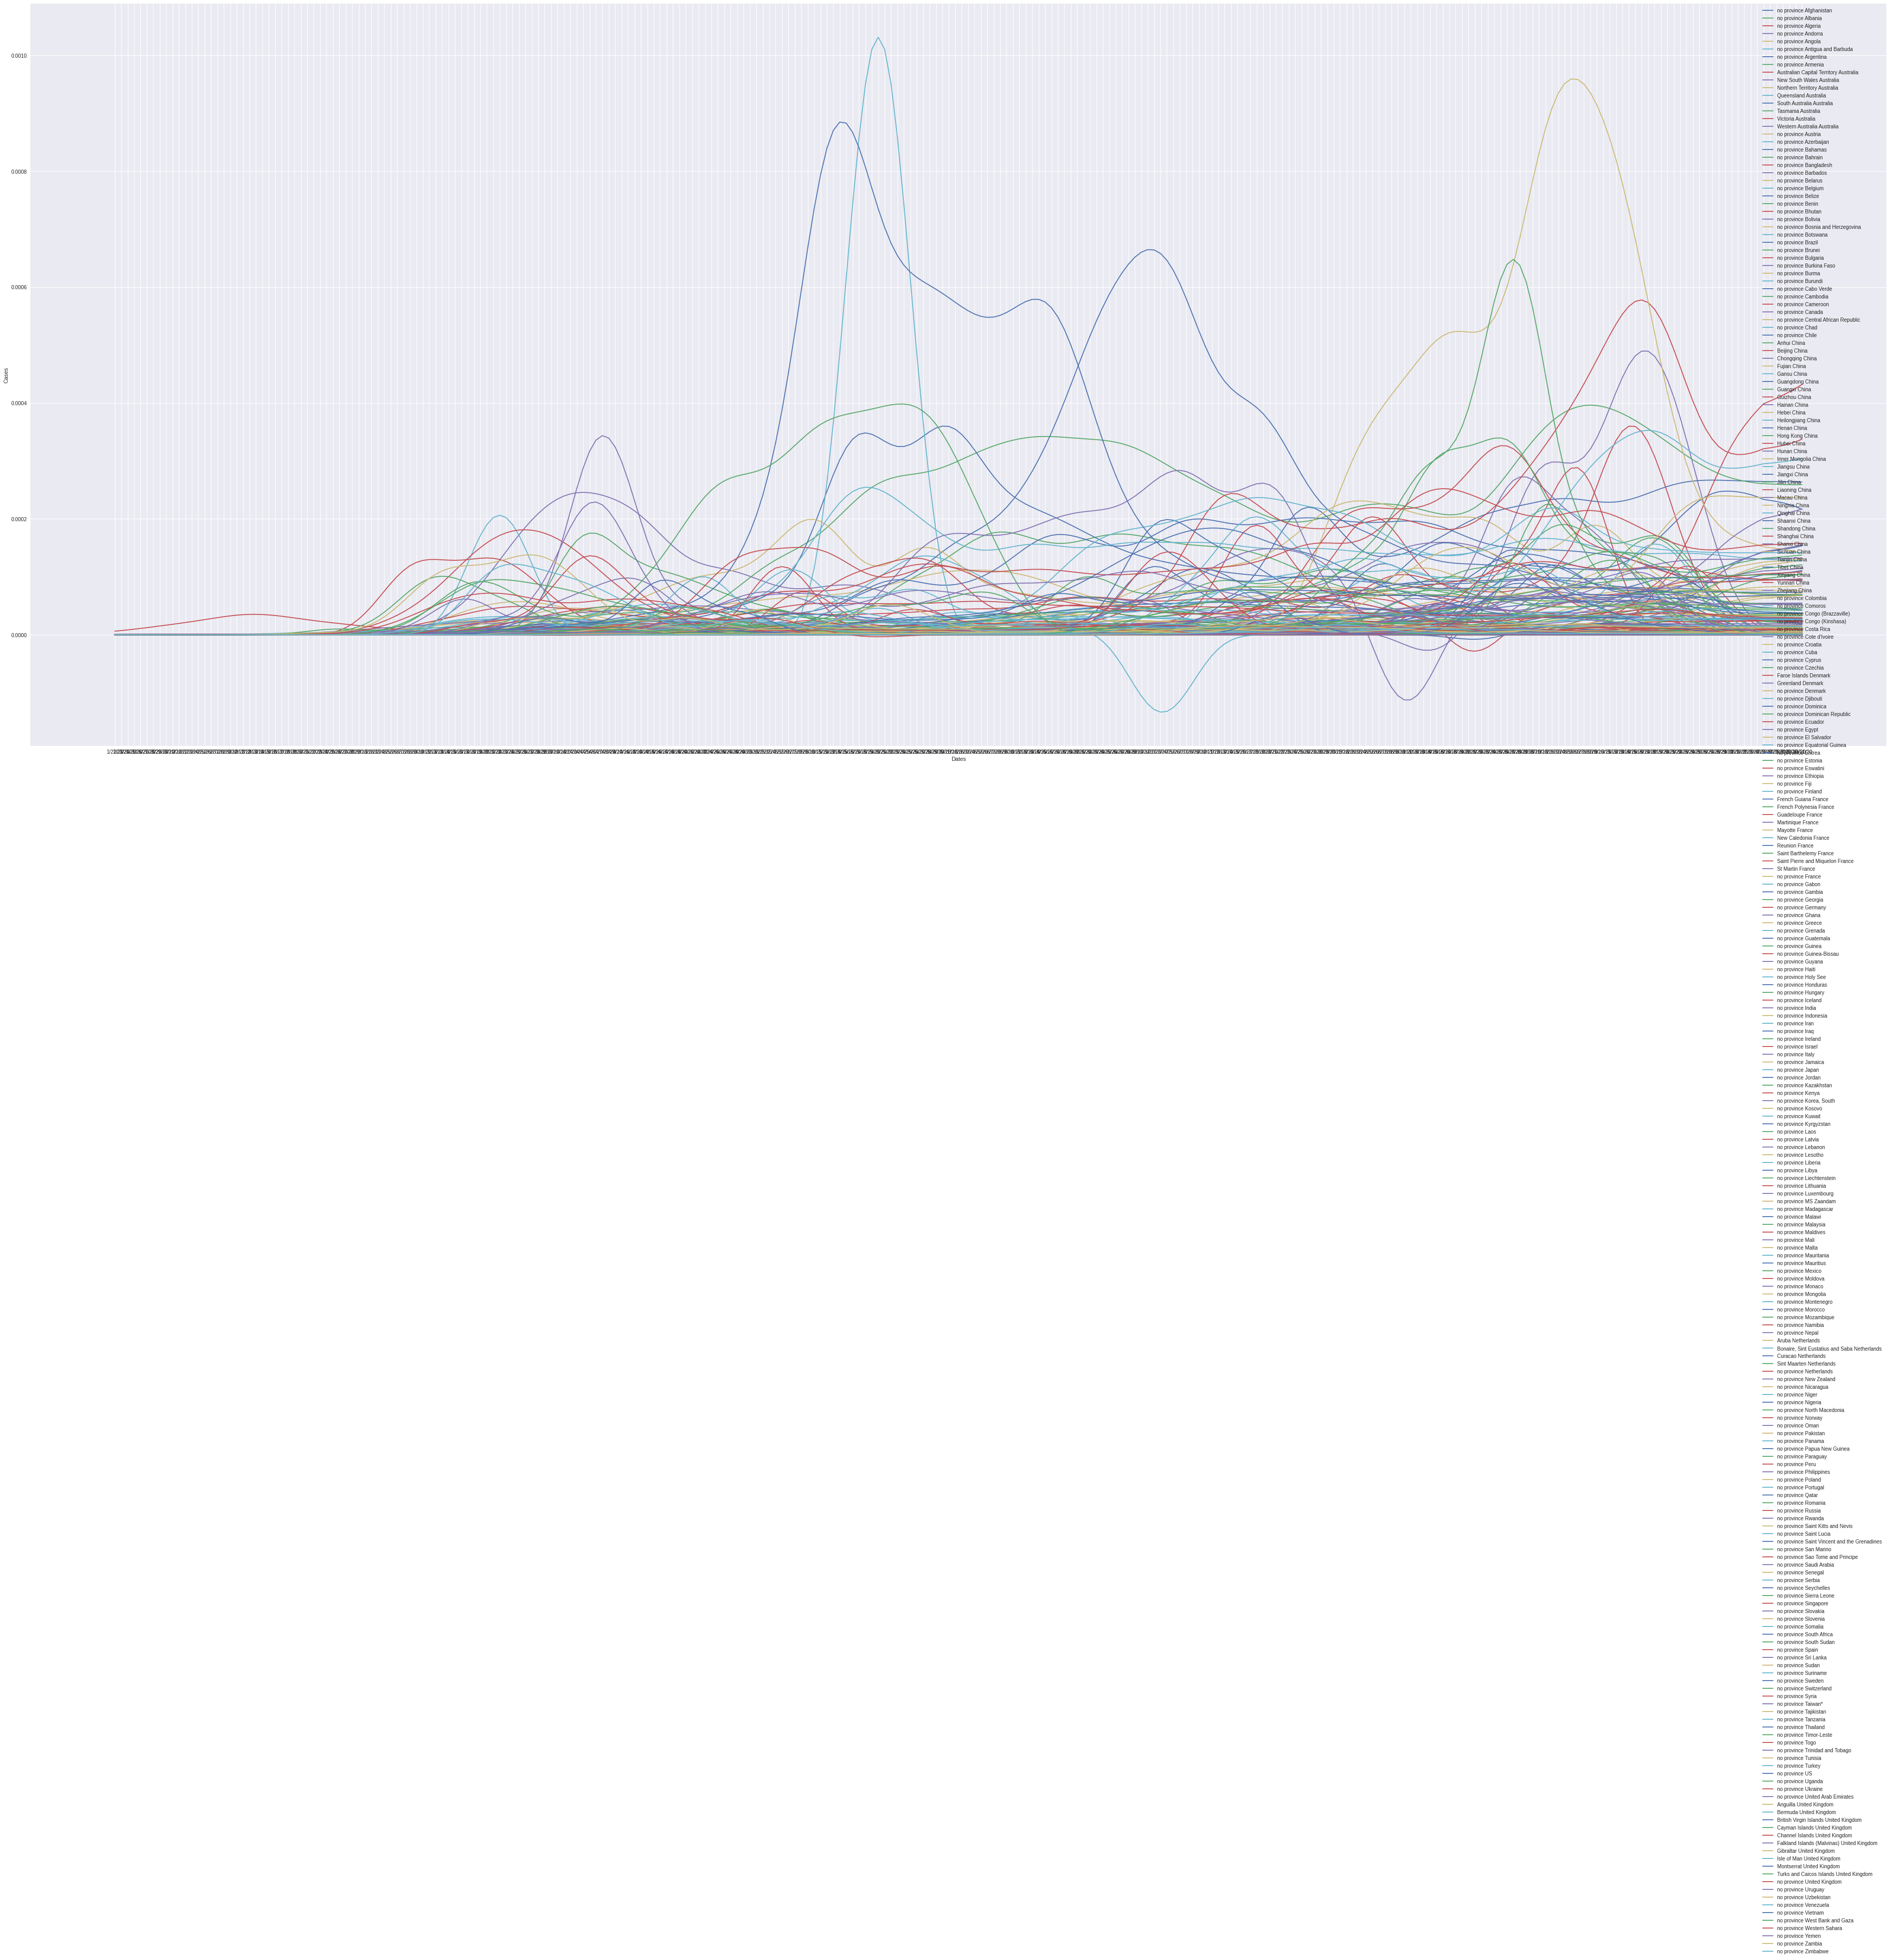

In [ ]:
get_graphs(smoothen_recovered, areas=smoothen_recovered['area'])

In [ ]:
shifts = [[] for i in range(252)]
lows=0.0002
mids=0.0004

In [ ]:
rown=0
for i in smoothen_recovered.iterrows():
    cur_tmp='low'
    next_tmp='low'
    same_counter=15
    for j in range(6,270):
        if i[1][j]<lows:
            next_tmp='low'
        elif i[1][j]<mids:
            next_tmp='mid'
        else:
            next_tmp='high'
        if cur_tmp==next_tmp:
            same_counter=same_counter+1
            if same_counter>=15:
                shifts[rown].append(next_tmp)
                cur_tmp=next_tmp
                same_counter=0
        else:
            same_counter=0
            shifts[rown].append(next_tmp)
            cur_tmp=next_tmp
            same_counter=0
    rown=rown+1

In [ ]:
vector_shifts=[[] for i in range(252)]
shift_change = {'lowlow':0, 'lowmid':1, 'midlow':2, 'midmid':3, 'midhigh':4, 'highmid':5, 'highhigh':6}

In [ ]:
for i in range(0, 252):
    for j in range(1, len(shifts[i])):
        vector_shifts[i].append(shift_change[shifts[i][j-1]+shifts[i][j]])

In [ ]:
number_of_shifts = [len(i) for i in shifts]

In [ ]:
number_of_shifts_added = smoothen_recovered.copy()
number_of_shifts_added['shifts']=number_of_shifts
number_of_shifts_added.head()

Province/State Country/Region       Lat  ...      10/10/20      10/11/20 shifts
0    no province    Afghanistan  33.93911  ...  1.266750e-06  1.284411e-06     18
1    no province        Albania  41.15330  ...  3.270731e-05  3.266387e-05     18
2    no province        Algeria  28.03390  ...  3.670095e-08  0.000000e+00     18
3    no province        Andorra  42.50630  ...  0.000000e+00  0.000000e+00     21
4    no province         Angola -11.20270  ...  8.234125e-07  8.215109e-07     18

[5 rows x 271 columns]

In [ ]:
max(number_of_shifts)

22

In [ ]:
for i in vector_shifts:
    while(len(i))<22:
        i.append(-1)

In [ ]:
shifts_added = number_of_shifts_added.copy()
for i in range(1, 23):
    name='shift '+str(i)
    tmp=[]
    for j in vector_shifts:
        tmp.append(j[i-1])
    shifts_added[name]=tmp
shifts_added.head()

Province/State Country/Region       Lat  ...  shift 20  shift 21 shift 22
0    no province    Afghanistan  33.93911  ...        -1        -1       -1
1    no province        Albania  41.15330  ...        -1        -1       -1
2    no province        Algeria  28.03390  ...        -1        -1       -1
3    no province        Andorra  42.50630  ...         2        -1       -1
4    no province         Angola -11.20270  ...        -1        -1       -1

[5 rows x 293 columns]

In [ ]:
#shifts_added.to_csv(os.path.join(BASE_DIR, 'recovered_added_features.csv'))